### Importações

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Conectando com o banco de Dados

Para diferenciar do que foi feito pela DSA porém mantendo a mesma ideia, usarei um conjunto de dados pessoal chamado de Diário de Trabalho. É um data lake construído para armazenar informações referentes a minha vida profissional: dias trabalhados, salario, hora extras, cargo...

In [2]:
# Conecta no banco de dados
con = sqlite3.connect('job_daily.db')

# Cria um cursor para o banco
cur = con.cursor()

A construção do data lake pode ser vista no github https://github.com/romerofernandes/ETL_HE . Em resumo, temos os seguintes registros:

 - Data: armazena a data
 - Dia_da_semana: armazena o dia da semana referente a coluna data
 - Mes: armazena o mês referente a data
 - Ano: armazena o ano referente a data
 - Feriado: armazena 'nao' caso a data for feriado ou armazena o nome do feriado caso seja
 - Cargo: armazena o nome do cargo na referida data
 - Regime_de_trabalho: armazena 'folga' para um dia de folga ou 'trabalho' para um dia de trabalho
 - Salario_Base: armazena o valor em P.U. do salario base na referida data
 - Salario_Bruto: armazena o valor em P.U. do salario bruto na referida data
 - Valor_HE_por_hora: armazena o valor em P.U. da hora extra por hora realizada na referida data
 - Hora_inicio: armazena o horario de inicio da hora extra executada na referida data caso haja
 - Hora_fim: armazena o horario final da hora extra executada na referida data caso haja
 - qtd_HE: armazena a quantidade de hora extra executada na referida data caso haja
 - HE_retorno: armazena 'Receber' para horas extras que foram pagas e 'Compensar' para horas extras compensadas
 - Tipo_HE: armazena 'Folga' para horas extras realizadas durante um dia de folga e 'Jornada Estendida' para horas extras durante dia de trabalho

In [3]:
# Importando os dados do Banco de Dados e exibindo uma amostra de 8 registros
job_daily = pd.read_sql_query('''SELECT * FROM Job_daily''', con)
job_daily.sample(8)

,Data,Dia_da_semana,Mes,Ano,Feriado,Cargo,Regime_de_trabalho,Salario_Base,Salario_Bruto,Valor_HE_por_hora,Hora_inicio,Hora_fim,qtd_HE,HE_retorno,Tipo_HE
3104,2021-02-10,Quarta-feira,Fevereiro,2021,Nao,COD,Trabalho,3.447214,4.653739,0.025854,None,None,0.0,None,None
3251,2021-07-06,Terça-feira,Julho,2021,Nao,COD,Trabalho,3.447214,4.653739,0.025854,None,None,0.0,None,None
1891,2017-12-19,Terça-feira,Dezembro,2017,Nao,Eletricista,Trabalho,1.841193,2.393550,0.011968,None,None,0.0,None,None
2109,2018-07-01,Domingo,Julho,2018,Nao,COD,Folga,2.988539,4.034528,0.022414,None,None,0.0,None,None
1320,2016-07-15,Sexta-feira,Julho,2016,Nao,Eletricista,Trabalho,1.587102,2.063233,0.010316,None,None,0.0,None,None
1470,2016-12-03,Sábado,Dezembro,2016,Nao,Eletricista,Folga,1.722008,2.238610,0.011193,None,None,0.0,None,None
778,2015-03-20,Sexta-feira,Março,2015,Nao,Eletricista,Trabalho,1.381420,1.795845,0.008979,None,None,0.0,None,None
383,2014-03-22,Sábado,Março,2014,Nao,Eletricista,Folga,1.261225,1.639592,0.008198,None,None,0.0,None,None


### 1 - Como foi a evolução no tempo das horas extras?

In [4]:
query1 = '''SELECT Mes, Ano, SUM(qtd_HE) AS qtd_HE_mes 
            FROM Job_daily 
            GROUP BY Ano, Mes
            ORDER BY Ano''' 

In [5]:
#Agrupamento de horas extras por mês e por ano
df_timeline = pd.read_sql_query(query1, con)
df_timeline

,Mes,Ano,qtd_HE_mes
0,Abril,2013,0.0
1,Agosto,2013,0.0
2,Dezembro,2013,19.5
3,Julho,2013,0.0
4,Junho,2013,0.0
...,...,...,...
101,Maio,2021,2.0
102,Março,2021,46.0
103,Novembro,2021,8.0
104,Outubro,2021,21.0


In [6]:
#lista com os meses do ano ordenados cronologicamente
meses_ano = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", 
          "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]

In [7]:
#Cria uma categoria com a lista de meses do ano, dessa forma os gráficos serão ordenados de forma cronológica
df_timeline['Mes'] = pd.Categorical(df_timeline['Mes'], categories=meses_ano, ordered=True)

In [8]:
#Função para colocar os valores sobre as barras nos gráficos de barras
def values_text(graf):
    for bar in graf.patches:
        graf.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.02,
            round(bar.get_height(),1),
            horizontalalignment='center',
            color= 'black'
            )

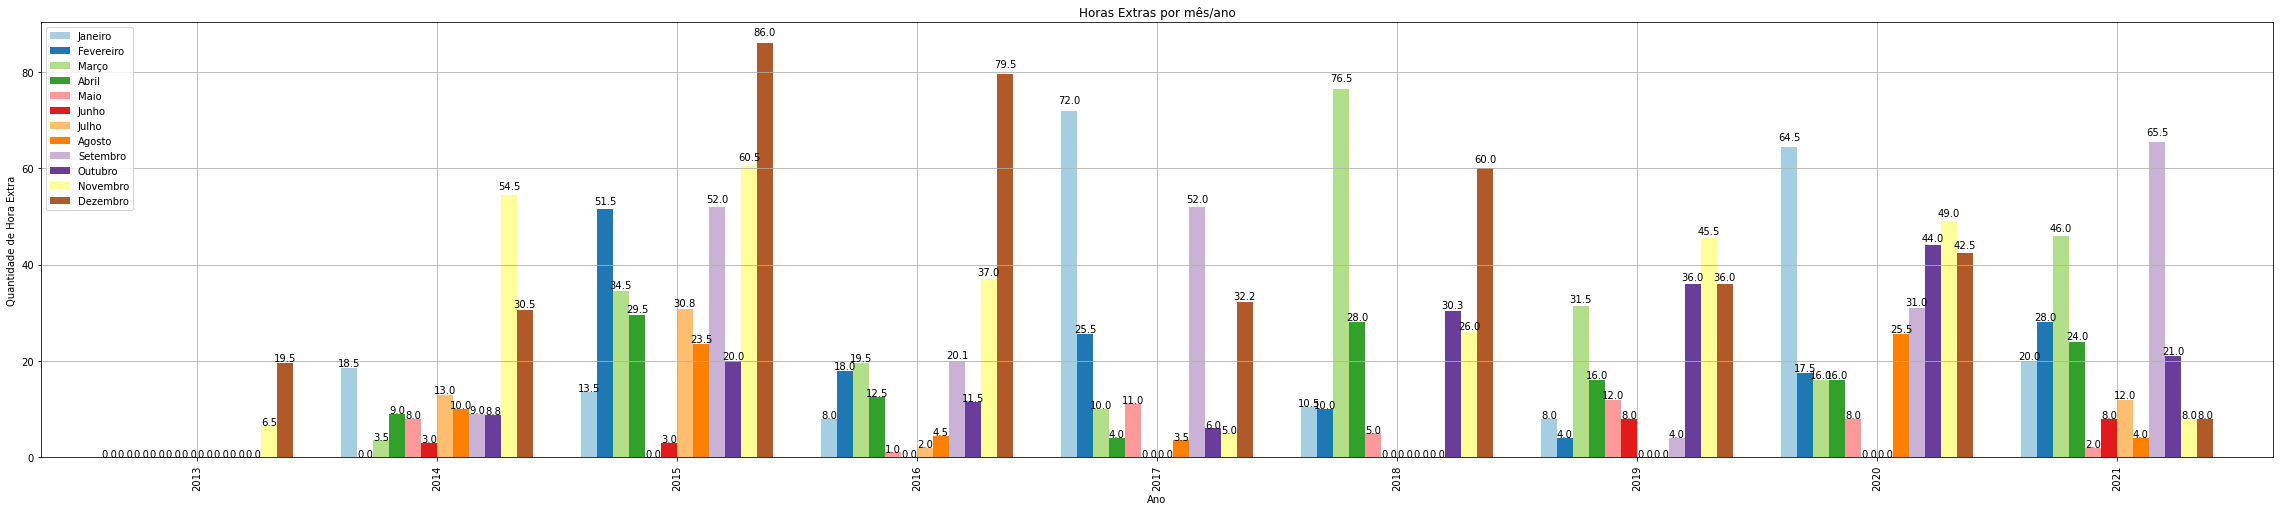

In [9]:
#Gráfico de horas extras a cada mês e agrupado por ano
ax = df_timeline.pivot("Ano", "Mes", "qtd_HE_mes").plot(kind='bar',
                                           title='Horas Extras por mês/ano',
                                           grid=True,
                                           ylabel='Quantidade de Hora Extra',
                                           xlabel='Ano',
                                           width = 0.8,
                                           colormap='Paired')

values_text(ax)

ax.legend(loc='upper left')
plt.gcf().set_size_inches(40, 8)

### 2 - Qual a média de horas extra por ano?

In [10]:
query2 = '''SELECT Ano, SUM(qtd_HE) AS qtd_HE_ano 
            FROM Job_daily 
            GROUP BY Ano
            ORDER BY Ano''' 

In [11]:
df_year = pd.read_sql_query(query2, con)
df_year

,Ano,qtd_HE_ano
0,2013,26.00
1,2014,167.75
2,2015,404.75
3,2016,213.59
4,2017,221.17
5,2018,246.33
6,2019,201.00
7,2020,314.00
8,2021,246.50


In [12]:
#Função para definir as configurações de plotagem a fim de padronizar os gráficos
def config_graph(graf):
    #Configura tamanho da figura
    plt.rcParams['figure.figsize'] = (10,7)
    
    # Rotaçao em 50 graus dos nomes dos meses
    plt.xticks(rotation=50)
    
    # Remove as margens laterais e a superior.
    graf.spines['top'].set_visible(False)
    graf.spines['right'].set_visible(False)
    graf.spines['left'].set_visible(False)

    # Define a cor cinza para a margem inferior
    graf.spines['bottom'].set_color('#DDDDDD')

    # Configura as linhas de grade para não sobreporem as barras
    graf.set_axisbelow(True)

    # Define a grade horizontal como visivel e na cor cinza
    graf.yaxis.grid(True, color='#EEEEEE')
    
    # Define o tamanho da letra de título
    plt.rcParams['axes.titlesize'] = 15
    
    #Cria legenda automaticamente usando as informacoes do objeto 'ax'
    handles, labels = graf.get_legend_handles_labels()
    graf.legend(handles, labels,loc="upper left")

    # Make the chart fill out the figure better.
    fig.tight_layout()

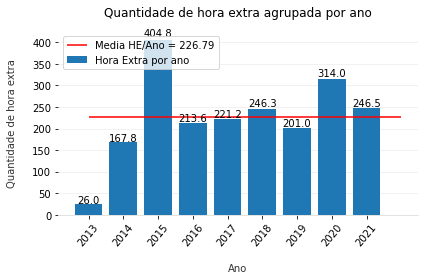

In [13]:
#cria subplot
fig, ax = plt.subplots()

#cria as barras
ax.bar(
    x=np.arange(df_year.Ano.size),
    tick_label=df_year.Ano,
    height=df_year['qtd_HE_ano'],
    label='Hora Extra por ano'
    )

# Define os nomes dos eixos x e Y
ax.set_ylabel('Quantidade de hora extra', labelpad=15, color='#333333')
ax.set_xlabel('Ano', labelpad=15, color='#333333')

# Define o titulo do grafico
ax.set_title('Quantidade de hora extra agrupada por ano', pad=15, color='black')

#Calculo media
media = df_year['qtd_HE_ano'].mean()

# Cria uma reta com o valor médio de hora extra por mês 
mean_HE_line = ax.hlines(media,
                         0,
                         df_year['qtd_HE_ano'].size,
                         colors='r', 
                         label='Media HE/Ano'+ ' = ' + str(round(media, 2)))

values_text(ax)

config_graph(ax)

### 3 - Qual a média mensal de horas extras ?

In [14]:
# Criando dataframe com a média mensal de horas extras
df_month = df_timeline.groupby('Mes').qtd_HE_mes.mean().reset_index().round(2)
df_month

,Mes,qtd_HE_mes
0,Janeiro,26.88
1,Fevereiro,19.31
2,Março,26.39
3,Abril,15.44
4,Maio,5.22
5,Junho,2.44
6,Julho,6.42
7,Agosto,7.89
8,Setembro,25.95
9,Outubro,19.73


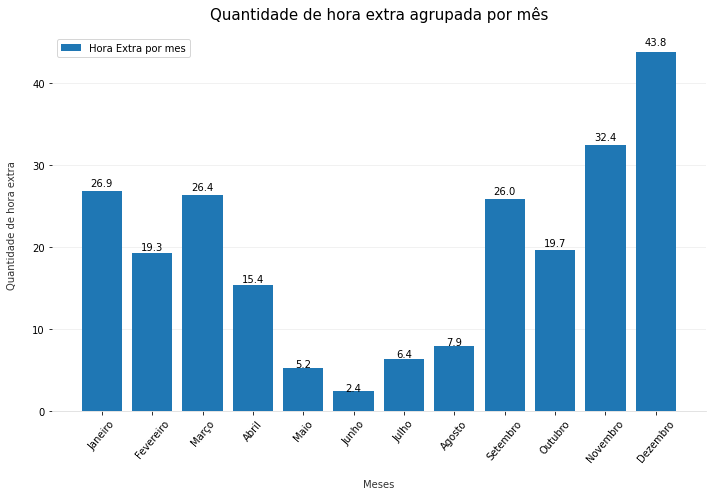

In [15]:
#cria subplot
fig, ax = plt.subplots()

ax.bar(
    x=np.arange(df_month.Mes.size),
    tick_label=df_month.Mes,
    height=df_month['qtd_HE_mes'],
    label='Hora Extra por mes'
        )

# adiciona anotações padronizadas
values_text(ax)

# Define os nomes dos eixos x e Y
ax.set_xlabel('Meses', labelpad=15, color='#333333')
ax.set_ylabel('Quantidade de hora extra ', labelpad=15, color='#333333')

# Define o titulo do grafico
ax.set_title('Quantidade de hora extra agrupada por mês', pad=15, color='black')

config_graph(ax)


### 4 - Qual o retorno financeiro das Horas Extras?

Farei o desenvolvimento de duas formas diferentes. A primeira fazendo uma query simples ao banco de dados para em seguida manipular o dataset resultante. A segunda fazendo uma query mais elaborada dispensando a manipulação do dataset.

###### 4.1 - Query simples

In [16]:
query3 = '''SELECT Data, Mes, Ano, Cargo, Salario_Bruto, Valor_HE_por_hora, qtd_HE, Tipo_HE 
            FROM Job_daily 
            WHERE HE_retorno = 'Receber' '''

In [17]:
df_return = pd.read_sql_query(query3, con)
df_return

,Data,Mes,Ano,Cargo,Salario_Bruto,Valor_HE_por_hora,qtd_HE,Tipo_HE
0,2013-11-18,Novembro,2013,Eletricista,1.510924,0.007555,1.5,Jornada Estendida
1,2013-11-19,Novembro,2013,Eletricista,1.510924,0.007555,1.5,Jornada Estendida
2,2013-11-19,Novembro,2013,Eletricista,1.510924,0.007555,1.5,Jornada Estendida
3,2013-11-27,Novembro,2013,Eletricista,1.510924,0.007555,1.0,Jornada Estendida
4,2013-11-27,Novembro,2013,Eletricista,1.510924,0.007555,1.0,Jornada Estendida
...,...,...,...,...,...,...,...,...
709,2021-10-09,Outubro,2021,COD,4.653739,0.025854,2.5,Folga
710,2021-10-12,Outubro,2021,COD,4.653739,0.025854,8.0,Jornada Estendida
711,2021-10-17,Outubro,2021,COD,4.653739,0.025854,4.0,Jornada Estendida
712,2021-11-02,Novembro,2021,COD,4.653739,0.025854,8.0,Jornada Estendida


In [18]:
#Criando coluna com o valor recebido por cada registro de Hora Extra
#Regra: Horas extras realizadas na folga valem 200% da hora e realizadas estendendo jornada valem 180%
df_return['Valor_Recebido'] = df_return.apply(lambda x:
                                                      x['Valor_HE_por_hora'] * x['qtd_HE'] * 2 if x['Tipo_HE'] == 'Folga'
                                                   else x['Valor_HE_por_hora'] * x['qtd_HE'] * 1.8,
                                                   axis=1)

In [19]:
df_return.head()

,Data,Mes,Ano,Cargo,Salario_Bruto,Valor_HE_por_hora,qtd_HE,Tipo_HE,Valor_Recebido
0,2013-11-18,Novembro,2013,Eletricista,1.510924,0.007555,1.5,Jornada Estendida,0.020397
1,2013-11-19,Novembro,2013,Eletricista,1.510924,0.007555,1.5,Jornada Estendida,0.020397
2,2013-11-19,Novembro,2013,Eletricista,1.510924,0.007555,1.5,Jornada Estendida,0.020397
3,2013-11-27,Novembro,2013,Eletricista,1.510924,0.007555,1.0,Jornada Estendida,0.013598
4,2013-11-27,Novembro,2013,Eletricista,1.510924,0.007555,1.0,Jornada Estendida,0.013598


In [20]:
#Agrupamento da quantidade de Horas extras e do valor recebido por cargo ocupado na empresa
df_retorno_cargo1 = df_return.groupby('Cargo').agg({'Valor_Recebido':'sum', 'qtd_HE':'sum'})
df_retorno_cargo1

,Valor_Recebido,qtd_HE
Cargo,,
COD,39.796131,853.83
Eletricista,21.820581,1142.26


In [21]:
# Totalização dos dados
total_recebido = df_return['Valor_Recebido'].sum()
total_HE = df_return.qtd_HE.sum()
print(f'O valor recebido por {round(total_HE,2)} horas extras realizadas foi de {round(total_recebido,2)} p.u.')

O valor recebido por 1996.09 horas extras realizadas foi de 61.62 p.u.


###### 4.2 Query mais elaborada

In [22]:
# query para um novo dataframe onde teremos Mes, Ano, Salario_Bruto, Cargo
query4 = '''WITH tab_retorno as (
                                SELECT Cargo,
                                       IIF(Tipo_HE = 'Folga', 
                                           (Valor_HE_por_hora * qtd_HE) * 2,
                                           (Valor_HE_por_hora * qtd_HE) * 1.8) as 'Retorno',
                                qtd_HE
                                FROM Job_daily
                                WHERE HE_retorno = 'Receber')
                                
                                SELECT Cargo,
                                       SUM(Retorno) as 'Retorno Financeiro',
                                       SUM(qtd_HE) as 'qtd_HE'
                   
                                FROM tab_retorno
                                GROUP BY Cargo
                                ORDER BY 'Retorno Financeiro' ''' 

In [23]:
# dataframe retorno financeiro agrupado por Cargo
df_retorno_cargo2 = pd.read_sql_query(query4, con)
df_retorno_cargo2

,Cargo,Retorno Financeiro,qtd_HE
0,COD,39.796131,853.83
1,Eletricista,21.820581,1142.26


In [24]:
# Totalização dos dados
total_recebido2 = df_retorno_cargo2['Retorno Financeiro'].sum()
total_HE2 = df_retorno_cargo2.qtd_HE.sum()
print(f'O valor recebido por {round(total_HE2,2)} horas extras realizadas foi de {round(total_recebido2,2)} p.u.')

O valor recebido por 1996.09 horas extras realizadas foi de 61.62 p.u.


### 5 - Qual o melhor mês para se tirar férias de forma a maximizar o redimento anual?

Essa é uma pergunta que eu ja me fiz por algumas vezes e hoje posso responder baseado em dados. Para responder o questionamento temos que identificar qual o mês cuja salário recebido (salario bruto + Horas extras realizadas entre os dias 13 do mês anterior e 12 do mês atual) foi o menor. Vamos então calcular os sálarios recebidos:

In [25]:
# tranformando o tipo de dado da coluna data para datetime
df_return.Data = pd.to_datetime(df_return.Data)

In [26]:
#construção do dataframe somando as horas extras realizadas entre os dias 13 do mês anterior e 12 do mês atual
salario_mes = pd.DataFrame(columns = ['Mes', 'Ano', 'qtd_HE', 'Valor'])
for ano in df_return.Ano.unique():
    for i, mes in enumerate(meses_ano, start=1):
        qtd = 0
        valor = 0
        if mes != 'Janeiro':
            inicio = df_return.Data > pd.to_datetime(str(ano)+'-'+ str(i-1)+'-' + '12')
            fim = df_return.Data < pd.to_datetime(str(ano)+'-'+ str(i)+'-' + '13')
            qtd = df_return['qtd_HE'].loc[inicio & fim].sum()
            valor = valor + df_return['Valor_Recebido'].loc[inicio & fim].sum()
            
        else:
            inicio = df_return.Data > pd.to_datetime(str(ano-1)+'-'+ str(12)+'-' + '12')
            fim = df_return.Data < pd.to_datetime(str(ano)+'-'+ str(1)+'-' + '13')
            qtd = df_return['qtd_HE'].loc[inicio & fim].sum()
            valor = valor + df_return['Valor_Recebido'].loc[inicio & fim].sum()
        
        salario_mes = pd.concat([salario_mes,
                                      pd.DataFrame({'Mes':[mes],
                                                    'Ano':[ano],
                                                    'qtd_HE':[round(qtd, 2)],
                                                    'Valor':[round(valor, 2)]})],
                                     ignore_index=True)

# Deletado as duas primeiras linhas pois todos os registros se iniciam em março de 2013 (inicio do contrato de trabalho)
salario_mes.drop([0,1], inplace=True)

In [27]:
salario_mes

,Mes,Ano,qtd_HE,Valor
2,Março,2013,0.0,0.00
3,Abril,2013,0.0,0.00
4,Maio,2013,0.0,0.00
5,Junho,2013,0.0,0.00
6,Julho,2013,0.0,0.00
...,...,...,...,...
103,Agosto,2021,12.0,0.60
104,Setembro,2021,32.0,1.57
105,Outubro,2021,54.5,2.72
106,Novembro,2021,12.0,0.56


In [28]:
# query para um novo dataframe onde teremos Mes, Ano, Salario_Bruto, Cargo
query5 = '''SELECT Mes, Ano, Salario_Bruto, Cargo 
            FROM Job_daily 
            GROUP BY Mes, Ano''' 

In [29]:
# dataframe temporário com informações de Mes, Ano, Salario_Bruto, Cargo
df_temp = pd.read_sql_query(query5, con)

# Categorização da coluna Mes para usá-la em ordem cronológica
df_temp['Mes'] = pd.Categorical(df_temp['Mes'], categories=meses_ano, ordered=True)

# Reorganização das linhas em ordem cronológica
df_temp = df_temp.sort_values(['Ano', 'Mes'])

In [30]:
# Adicionando coluna Salario Bruto no dataframe Salario_mes
salario_mes['Salario_Bruto'] = df_temp['Salario_Bruto'].values

# Adicionando coluna cargo no dataframe Salario_mes
salario_mes['Cargo'] = df_temp['Cargo'].values

In [31]:
# Criando a coluna Salario Recebido
salario_mes['Salario_Recebido'] = salario_mes['Valor'] + salario_mes['Salario_Bruto']

In [32]:
# Visualizando os 10 maiores salarios recebidos
salario_mes.sort_values('Salario_Recebido', ascending=False).head(10)

,Mes,Ano,qtd_HE,Valor,Salario_Bruto,Cargo,Salario_Recebido
105,Outubro,2021,54.5,2.72,4.653739,COD,7.373739
96,Janeiro,2021,50.5,2.52,4.653739,COD,7.173739
98,Março,2021,49.0,2.47,4.653739,COD,7.123739
95,Dezembro,2020,49.0,2.37,4.653739,COD,7.023739
83,Dezembro,2019,56.0,2.59,4.354765,COD,6.944765
99,Abril,2021,41.0,2.05,4.653739,COD,6.703739
92,Setembro,2020,46.0,2.17,4.354765,COD,6.524765
94,Novembro,2020,40.0,1.84,4.653739,COD,6.493739
85,Fevereiro,2020,44.5,2.06,4.354765,COD,6.414765
104,Setembro,2021,32.0,1.57,4.653739,COD,6.223739


Agora estamos aptos a responder qual o mês teve o menor salário.

In [33]:
salario_medio_mes = salario_mes.groupby(['Mes']).aggregate({'Salario_Recebido': 'mean'})

In [34]:
# Visualização dos salarios medios do menor para o maior
salario_medio_mes.sort_values('Salario_Recebido')

,Salario_Recebido
Mes,
Junho,2.837265
Julho,3.038984
Agosto,3.081207
Maio,3.103932
Abril,3.205043
Fevereiro,3.494302
Setembro,3.495713
Março,3.650599
Outubro,3.688724


Para maximizar o rendimento anual o ideal seria tirar férias no mês de junho.

### Encerrando conexão com banco de dados

In [35]:
# fecha a conexão com o banco de dados
con.close()